In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv(r"C:\Users\ALVI\Downloads\Compressed\1014_4361_bundle_archive\Bangla_NER_Dataset.csv", encoding="UTF-8")


In [2]:
data = data.fillna(method="ffill")


In [3]:
data.tail(10)


,Sentence #,Word,Tag
297407,Sentence: 22145,ফিরে,O
297408,Sentence: 22145,এসে,O
297409,Sentence: 22145,ভালোবাসা,O
297410,Sentence: 22145,নিয়েই,O
297411,Sentence: 22145,নতুন,O
297412,Sentence: 22145,করে,O
297413,Sentence: 22145,শুরু,O
297414,Sentence: 22145,হোক,O
297415,Sentence: 22145,পথ,O
297416,Sentence: 22145,চলা,O


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words


34237

In [5]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags


17

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [7]:
getter = SentenceGetter(data)


In [8]:
sent = getter.get_next()


In [9]:
print(sent)


[('বাংলাদেশে', 'B-geo'), ('কক্সবাজার', 'B-geo'), ('এলাকায়', 'O'), ('রোহিঙ্গাদের', 'B-gpe'), ('জন্য', 'O'), ('নির্ধারিত', 'O'), ('আশ্রয়', 'O'), ('শিবিরের', 'O'), ('বাইরে', 'O'), ('বেরুলে', 'O'), ('তাদের', 'O'), ('গ্রেপ্তার', 'O'), ('করা', 'O'), ('হবে', 'O'), ('বলে', 'O'), ('জানিয়েছেন', 'O'), ('পুলিশের', 'O'), ('মহাপরিদর্শক', 'O'), ('একেএম', 'B-per'), ('শহীদুল', 'I-per'), ('হক', 'I-per')]


In [10]:
sentences = getter.sentences


In [11]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}


In [12]:
tag2idx["B-geo"]


16

In [13]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]


In [14]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)


In [15]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]


In [16]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])


In [17]:
from keras.utils import to_categorical


In [18]:
y = [to_categorical(i, num_classes=n_tags) for i in y]


In [19]:
from sklearn.model_selection import train_test_split


In [20]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)


In [22]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tf2crf import CRF


c:\users\alvi\appdata\local\programs\python\python38\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:38: UserWarning: You are currently using a nightly version of TensorFlow (2.4.0-dev20200902). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [23]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output


In [24]:
model = Model(input, out)


In [28]:
model.compile(optimizer="rmsprop", loss=crf.loss, metrics=[crf.accuracy])


In [29]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 75, 20)            684760    
_________________________________________________________________
bidirectional (Bidirectional (None, 75, 100)           28400     
_________________________________________________________________
time_distributed (TimeDistri (None, 75, 50)            5050      
_________________________________________________________________
crf (CRF)                    (None, 75)                2500      
Total params: 720,710
Trainable params: 720,710
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)


Epoch 1/5
561/561 [==============================] - 133s 212ms/step - loss: 3.0669 - accuracy: 0.8196 - val_loss: 5.4823 - val_accuracy: 0.8726
Epoch 2/5
561/561 [==============================] - 105s 187ms/step - loss: 1.1348 - accuracy: 0.8743 - val_loss: 4.2488 - val_accuracy: 0.9001
Epoch 3/5
561/561 [==============================] - 105s 187ms/step - loss: 0.7639 - accuracy: 0.9014 - val_loss: 3.3942 - val_accuracy: 0.9173
Epoch 4/5
561/561 [==============================] - 102s 182ms/step - loss: 0.5821 - accuracy: 0.9221 - val_loss: 2.9422 - val_accuracy: 0.9279
Epoch 5/5
561/561 [==============================] - 104s 185ms/step - loss: 0.4277 - accuracy: 0.9424 - val_loss: 2.6945 - val_accuracy: 0.9326


In [31]:
hist = pd.DataFrame(history.history)


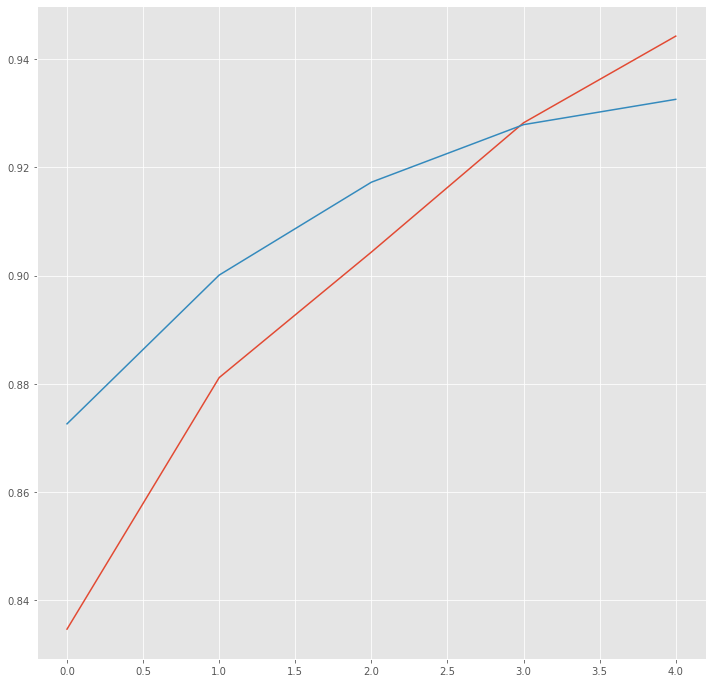

In [33]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()


In [60]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


In [66]:
test_pred = model.predict(X_te, verbose=1)


70/70 [==============================] - 3s 36ms/step


In [62]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)


In [67]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))


F1-score: 0.0%


In [68]:
print(classification_report(test_labels, pred_labels))


           precision    recall  f1-score   support

      geo       0.00      0.00      0.00      1046
      org       0.00      0.00      0.00       545
      gpe       0.00      0.00      0.00       236
      per       0.00      0.00      0.00       964
      tim       0.00      0.00      0.00       505
      eve       0.00      0.00      0.00        55
      art       0.00      0.00      0.00        44
      nat       0.00      0.00      0.00         9

micro avg       0.00      0.00      0.00      3404
macro avg       0.00      0.00      0.00      3404

